#### The purpose of this EDA notebook is the following:
- Better understand the nature of the relationship between the independent variables
- Create an initial model with reasonable economic assumptions that may be dropped in later versions
- Explore methods of imputation for missing variables to provide more data samples
- Avoid linear combinations that might be more difficult to spot in the Bayesian Modeling process
- Establish a reasonable measure of variable importance, which along with correlation plots may inform initial hierarchies
- Create visualizations of poor quality data and also establish probability distributions for the likelihood function

#### 1. Import data and necessary packages

In [4]:
import os
# os.environ['KERAS_BACKEND'] = 'theano'
# os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=cuda0,optimizer=fast_compile'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
# from rfpimp import *
# from rfpimp import plot_corr_heatmap
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.optimize import curve_fit
from scipy.stats import linregress
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from multiprocessing import Pool
import importlib
from sklearn.inspection import permutation_importance
# import category_encoders as ce
# from catboost import CatBoostRegressor, Pool
import arviz as az
import pymc3 as pm
import theano
import theano.tensor as tt
from sklearn import preprocessing
# import shap
import mkl
from statsmodels.stats.outliers_influence import variance_inflation_factor
from fitter import Fitter, get_common_distributions, get_distributions
import xarray
from sklearn.metrics import mean_squared_error
from pymc3.variational.callbacks import CheckParametersConvergence

# %load_ext timeit
# %load_ext heat
# %load_ext line_profiler
# %load_ext memory_profiler

In [5]:
df = pd.read_csv('C:/Users/norri/Desktop/cortex_Push_2.csv')
df_bu = df
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82209 entries, 0 to 82208
Data columns (total 89 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   ClientId                                          82209 non-null  int64  
 1   Program Id                                        82209 non-null  int64  
 2   Program Name                                      82209 non-null  object 
 3   Retailers                                         82209 non-null  object 
 4   TacticId                                          82209 non-null  int64  
 5   Tactic                                            82209 non-null  object 
 6   CategoryId                                        82209 non-null  int64  
 7   Tactic Category                                   82209 non-null  object 
 8   VendorId                                          80053 non-null  float64
 9   Vendor           

Pandas dataframes will have string, int, and float columns. The following
three sections will look for columns that need to be fixed or ped altogether

##### The following few sections analyze categorical, float, and int variables
##### so the dataset can be cleaned

In [6]:
df = df.drop(['Program Name', 'Retailers', 'Tactic', 'Vendor', 'Tactic Start Date',
              'Tactic End Date'], axis=1)
segment = [var for var in df.columns if df[var].dtype == 'O']
print('There are {} categorical variables\n'.format(len(segment)))
print('The categorical variables are :\n\n', segment)
print(df[segment].isnull().sum() / len(df))
df_cat = df.select_dtypes(include=object)
df_cat.info()
df_cat.describe()
print(df_cat.nunique())

There are 6 categorical variables

The categorical variables are :

 ['Tactic Category', 'Brand', 'RMN', 'Product', 'Geography', 'Time']
Tactic Category    0.0
Brand              0.0
RMN                0.0
Product            0.0
Geography          0.0
Time               0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82209 entries, 0 to 82208
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Tactic Category  82209 non-null  object
 1   Brand            82209 non-null  object
 2   RMN              82209 non-null  object
 3   Product          82209 non-null  object
 4   Geography        82209 non-null  object
 5   Time             82209 non-null  object
dtypes: object(6)
memory usage: 3.8+ MB
Tactic Category     12
Brand               36
RMN                  2
Product            121
Geography           11
Time                76
dtype: int64


In [7]:
df.RMN.replace(('Yes', 'No'), (1, 0), inplace=True)

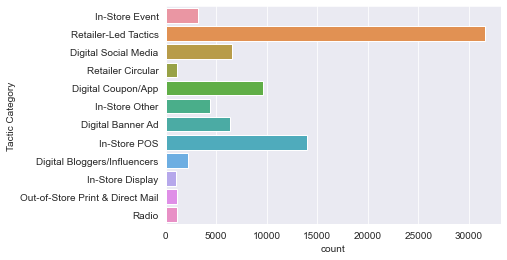

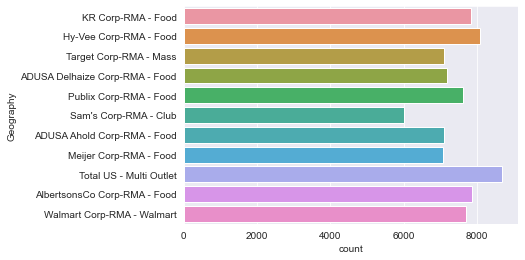

In [8]:
for col in df.select_dtypes(include='object'):
    if df[col].nunique() <= 25:
        sns.countplot(y=col, data=df)
        plt.show()

In [9]:
# df = df.drop(
#     [], axis=1)
integer = [var for var in df.columns if df[var].dtype == 'int64']
print('There are {} integer variables\n'.format(len(integer)))
print('The integer variables are :\n\n', integer)
print(df[integer].isnull().sum())
df_int = df.select_dtypes(include=int)
if len(df_int.columns) > 0.0:
    df_int.info()
    df_int.describe()

There are 11 integer variables

The integer variables are :

 ['ClientId', 'Program Id', 'TacticId', 'CategoryId', 'Total Impressions for Tactic', 'BrandId', 'Nielsen_Week_Year', 'StoreCount', 'RMN', 'Weeks', 'Number of Stores']
ClientId                        0
Program Id                      0
TacticId                        0
CategoryId                      0
Total Impressions for Tactic    0
BrandId                         0
Nielsen_Week_Year               0
StoreCount                      0
RMN                             0
Weeks                           0
Number of Stores                0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82209 entries, 0 to 82208
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   ClientId                      82209 non-null  int64
 1   Program Id                    82209 non-null  int64
 2   TacticId                      82209 non-nu

##### In the below section we address the large number of missing s and also
##### the columns consisting entirely of zeroes, and drop them accordingly

In [10]:
df = df.drop(
        ['Base $', 'Incr $', 'Base Units', 'Incr Units',
         '$ Shr - Ty Subcategory', 'Units Shr - Ty Category',
         'Units Shr - Ty Subcategory'], axis=1)
fp = [var for var in df.columns if df[var].dtype == 'float64']
print('There are {} float variables\n'.format(len(fp)))
print('The float variables are :\n\n', fp)
fp_na = df[fp].isnull().sum() / len(df) * 100
print(fp_na[fp_na > 10])
fp_zero = df[fp].sum()
print(fp_zero[fp_zero == 0.0])

There are 60 float variables

The float variables are :

 ['VendorId', 'Total Tactic Spend', 'Total Tactic Insertion Cost', 'Total Tactic Redemption Cost', 'Impressions per Week', 'Brand Share of Program Budget', 'Brand Share of Total Tactic Spend', 'Brand Share of Tactic Insertion Cost', 'Brand Share of Tactic Redemption Cost', 'Weekly Brand Share of Total Tactic Spend', 'Weekly Brand Share of Tactic Insertion Cost', 'Weekly Brand Share of Tactic Redemption Cost', 'Total Sales', 'Units', 'Avg Unit Price', 'Any Promo Units', '%ACV Distribution', 'Any Promo %ACV', 'Disp w/o Feat %ACV', 'Feat & Disp %ACV', 'Feat w/o Disp %ACV', 'Price Decr Only %ACV', 'Number of UPCs Selling', 'Dollar Sales', 'Dollar Sales No Merch', 'Dollar Sales Any Merch', 'Dollar Sales Price Reductions Only', 'Dollar Sales Feature Only', 'Dollar Sales Display Only', 'Dollar Sales Feature and Display', 'Dollar Sales Feature and/or Display', 'Dollar Sales Any Price Reduction', 'Dollar Sales Any Feature', 'Dollar Sales 

In [11]:
df = df.drop(
        ['ClientId', 'Program Id', 'TacticId', 'CategoryId',
         'BrandId', 'Nielsen_Week_Year', 'VendorId'], axis=1)
df_num = df.select_dtypes(exclude='object')
df_num.describe()

,Total Impressions for Tactic,Total Tactic Spend,Total Tactic Insertion Cost,Total Tactic Redemption Cost,StoreCount,RMN,Weeks,Impressions per Week,Brand Share of Program Budget,Brand Share of Total Tactic Spend,...,ACV Weighted Distribution Any Feature,ACV Weighted Distribution Any Display,Avg Weekly Items per Store Selling,Avg Weekly Units per Store Selling,Avg Weekly Dollars per Store Selling,Dollar Sales per Pt of Distribution,Unit Sales per Pt of Distribution,Number of Stores Selling,Weighted Average Base Price Per Unit,Number of Stores
count,8.220900e+04,82209.000000,82209.000000,82209.000000,82209.000000,82209.000000,82209.000000,8.220900e+04,82209.000000,82209.000000,...,46979.000000,66640.000000,82208.000000,82208.000000,82208.000000,8.220800e+04,82208.000000,82208.000000,82208.000000,82209.000000
mean,6.407302e+06,23489.700444,20927.899871,2561.800572,465.067657,0.460461,5.832756,1.586431e+06,0.696478,13261.905602,...,70.894942,42.382201,87.590972,793.434638,3977.836748,8.959253e+04,19353.740279,6846.854743,5.724381,13008.919060
std,1.792383e+07,24157.132416,22224.675386,13301.853242,962.855393,0.498437,7.223135,5.262126e+06,0.398124,15015.701018,...,36.051244,33.824562,142.564862,1278.918493,6227.849807,1.985870e+05,46798.691810,18654.479238,2.572143,33309.346708
min,0.000000e+00,11.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.002996,11.000000,...,0.000301,0.000568,1.000000,0.806123,0.509922,2.980000e-02,0.004660,1.000000,0.510000,237.000000
25%,2.402400e+04,7005.380000,3286.000000,0.000000,0.000000,0.000000,4.000000,4.744800e+03,0.250000,2004.046633,...,40.286984,7.699370,4.255066,42.963326,204.923915,2.928670e+03,579.986982,588.000000,3.922013,589.000000
50%,1.251171e+06,15450.000000,15000.000000,0.000000,0.000000,0.000000,4.000000,2.304797e+05,1.000000,8270.191252,...,93.948052,39.624288,33.094459,291.684583,1393.844261,1.882864e+04,3829.326973,1252.000000,5.188795,1286.000000
75%,3.000000e+06,30000.000000,30000.000000,0.000000,241.000000,1.000000,6.000000,6.250000e+05,1.000000,20000.000000,...,99.747747,73.837543,113.362142,999.558209,5125.612458,7.103080e+04,12917.946968,2258.000000,6.816732,2283.000000
max,1.277500e+08,126222.000000,126222.000000,114135.070000,3884.000000,1.000000,61.000000,4.258333e+07,1.000000,66062.000000,...,100.000000,100.000000,999.677600,19937.256100,69017.690480,2.864201e+06,804770.302900,93043.440570,35.005766,110632.000000


The following heat maps are obviously important for understanding relationships,
but more importantly their dataframes provide the ability to fill df.colnames
that will be key to making a decision on what variables to explore for feature importance

In [12]:
# corr = df_num.corr(method="spearman").round(2)
# mask = np.triu(np.ones_like(corr, dtype=bool))
# f, ax = plt.subplots(figsize=(18, 18))
# cmap = sns.diverging_palette(250, 1, as_cmap=True)
# sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})
# corr.describe()

Here we use the correlation df and filter by a minimum threshold, while
eliminating one to avoid including the variable itself
by converting it to a list, we can use it in our feature importance plots

In [13]:
# use VIF along with variable importance to check new dataframes
# vif_df = df_num[~df_num.isin([np.nan, np.inf, -np.inf]).any(1)]
#
# X = vif_df
# vif_data = pd.DataFrame()
# vif_data["feature"] = X.columns
# vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
# print(vif_data)
#
# corr_vif = vif_df.corr(method="spearman").round(2)
# mask = np.triu(np.ones_like(corr_vif, dtype=bool))
# plt.subplots(figsize=(18, 18))
# cmap = sns.diverging_palette(250, 1, as_cmap=True)
# sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})
# corr_vif.describe()

In [14]:
# df_num = df_num.drop(['Units', 'Impressions per Week',
#                       'Any Promo %ACV', '%ACV Distribution'], axis=1)
corr = df_num.corr(method="spearman").round(2)

In [15]:
# def imp_plots(target, predictors):
#     """Form three importance plots
#
#     :param target:'dependent' component
#     :param predictors:'predictive' component
#     """
#     target = target
#     df_all = df_num.dropna().astype(dtype='int32')
#     df_all = df_all[predictors + [target]]
#     df_train, df_test = train_test_split(df_all, test_size=0.15)
#     X_train, y_train = df_train.drop(target, axis=1), df_train[target]
#     X_test, y_test = df_test.drop(target, axis=1), df_test[target]
#     rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,
#                                 max_features=1.0,
#                                 min_samples_leaf=10, oob_score=True)
#     rf.fit(X_train, y_train)
#     RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#                            max_depth=None, max_features=1.0, max_leaf_nodes=None,
#                            min_impurity_decrease=0.0, min_samples_leaf=10,
#                            min_samples_split=2,
#                            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
#                            oob_score=True, random_state=None, verbose=0, warm_start=False)
#     figure, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
#     imp1 = importances(rf, X_test, y_test)
#     plot_importances(imp1, width=16, vscale=4, ax=ax1)
#
#     imp = pd.DataFrame()
#     imp['Feature'] = X_train.columns
#     imp['Importance'] = rf.feature_importances_
#     imp = imp.sort_values('Importance', ascending=False)
#     imp2 = imp.set_index('Feature')
#     plot_importances(imp2, width=16, vscale=4, ax=ax2)
#
#     perm_importance = permutation_importance(rf, X_test, y_test)
#     perm = pd.DataFrame()
#     perm['Feature'] = X_test.columns
#     perm['Importance'] = perm_importance.importances_mean
#     perm = perm.sort_values('Importance', ascending=False)
#     perm = perm.set_index('Feature')
#     plot_importances(perm, width=16, vscale=4, ax=ax3)
#     a = imp1.sort_values(by='Feature')
#     b = imp2.sort_values(by='Feature')
#     c = perm.sort_values(by='Feature')
#     d = (np.abs(a) + np.abs(b) + np.abs(c)).sort_values('Importance',
#                                                         ascending=False).mean(axis=1)
#     plt.show()
#     return d

The following three importance plots look at different ways to measure importance
in relation to predicting our variable of interest. We can continue this
process many times to develop our Bayesian Hierarchy

In [16]:
# corr_imp = corr[abs(corr['Total Sales'] > .20) & (corr['Total Sales'] < 1.0)]
# corr_imp = corr_imp[['Total Sales']]
# features = corr_imp.index.tolist()
# imp_sales = imp_plots('Total Sales', features)
# print(imp_sales)

In [17]:
# corr_imp = corr[abs(corr['Number of UPCs Selling'] > .20) & (corr['Number of UPCs Selling'] < 1.0)]
# corr_imp = corr_imp[['Number of UPCs Selling']]
# features = corr_imp.index.tolist()
# imp_UPC = imp_plots('Number of UPCs Selling', features)
# print(imp_UPC)

In [18]:
# corr_imp = corr[
#     abs(corr['Price Decr Only %ACV'] > .20) & (corr['Price Decr Only %ACV'] < 1.0)]
# corr_imp = corr_imp[['Price Decr Only %ACV']]
# features = corr_imp.index.tolist()
# imp_price_decr = imp_plots('Price Decr Only %ACV', features)
# print(imp_price_decr)

In [19]:
# corr_imp = corr[abs(corr['Any Promo Units'] > .20) & (corr['Any Promo Units'] < 1.0)]
# corr_imp = corr_imp[['Any Promo Units']]
# features = corr_imp.index.tolist()
# imp_promo_unit = imp_plots('Any Promo Units', features)
# print(imp_promo_unit)

In [20]:
# corr_imp = corr[
#     abs(corr['Feat w/o Disp %ACV'] > .20) & (corr['Feat w/o Disp %ACV'] < 1.0)]
# corr_imp = corr_imp[['Feat w/o Disp %ACV']]
# features = corr_imp.index.tolist()
# imp_feat_no_disp = imp_plots('Feat w/o Disp %ACV', features)
# print(imp_feat_no_disp)

This can be repeated for every variable of interest in the hierarchy
The below kde plots are crucial to understanding the likelihood function
distribution and beginning the Bayesian modeling

#### 2. This section continues on to modeling and exploration of modeling techniques

In [21]:
final_vars_cat = ['Number of UPCs Selling', 'Any Promo Units', '%ACV Distribution',
                  'Feat w/o Disp %ACV', 'Price Decr Only %ACV', 'Disp w/o Feat %ACV',
                  'Total Sales', 'Feat & Disp %ACV', 'RMN', 'Tactic Category', 'Brand']

final_vars = ['Number of UPCs Selling', 'Any Promo Units', '%ACV Distribution',
              'Feat w/o Disp %ACV', 'Price Decr Only %ACV', 'Disp w/o Feat %ACV',
              'Total Sales', 'Feat & Disp %ACV', 'RMN']

In [22]:
df_final = df[final_vars]

dist_list = ['gamma', 'expon', 'cauchy', 'norm', 'uniform']

for var in final_vars:
    dist_test = df_final[var].dropna()
    dist_test = dist_test.values
    f = Fitter(dist_test, distributions=dist_list, timeout=60)
    f.fit()
    print(var)
    print(f.summary(plot=False))
    print(f.get_best(method='sumsquare_error'))

Number of UPCs Selling
         sumsquare_error          aic            bic  kl_div
gamma           1.914466  1015.570094 -563293.837734     inf
expon           2.296087   840.781624 -553328.250451     inf
cauchy          2.536779   919.034151 -547856.725055     inf
norm            2.640389   925.178722 -545659.578088     inf
uniform         2.822980   612.904488 -541989.518996     inf
{'gamma': {'a': 0.20965298747919442, 'loc': 0.9999999999999999, 'scale': 6.7543191343959865}}
Any Promo Units
         sumsquare_error          aic           bic  kl_div
cauchy      3.617007e-07  2793.992427 -1.413044e+06     inf
gamma       4.654527e-07  2420.370345 -1.399191e+06     inf
expon       9.641510e-07  2539.350841 -1.359232e+06     inf
norm        1.313914e-06  2516.493875 -1.342244e+06     inf
uniform     1.383860e-06  2113.187031 -1.339397e+06     inf
{'cauchy': {'loc': 276.1308304252667, 'scale': 527.581424120705}}
%ACV Distribution
         sumsquare_error          aic            bic  kl_

##### 2.1 Here I tested the Bambi package to establish a baseline,
##### but it slows down the modeling process

In [23]:
# df_nostr = df[final_vars]
# df_nostr = df_nostr[df_nostr['Total Sales'] > 0.0]
# df_nostr.columns = df_nostr.columns.str.replace('[#,@,&,%,''//''," "]', '')
#
# df_nostr['TotalSales'] = np.log(df_nostr['TotalSales'])

In [24]:
# bmb_model = bmb.Model('TotalSales ~ NumberofUPCsSelling + '
#                       ' FeatwoDispACV + PriceDecrOnlyACV + DispwoFeatACV'
#                       , data=df_nostr, dropna=False)
#
# bmb_fitted = bmb_model.fit(draws=3000, tune=3000, chains=4)

##### 2.3 Here I test and get diagnostics for this model
##### and to prepare for the more complicated model

In [25]:
# az.plot_trace(bmb_fitted)
# print(az.summary(bmb_fitted))
# print(az.ess(bmb_fitted))
# az.plot_posterior(bmb_fitted, hdi_prob=0.99)
# az.plot_energy(bmb_fitted);

##### 2.4 Note the above graph and compare it to the
##### graph at the end. Having each chain closer to one
##### is the ideal

In [26]:
df_final_cat = df_bu[final_vars_cat]
df_final_cat = df_final_cat[df_final_cat['Total Sales'] > 0.0]

The following two charts show that many Tactic Category observations have dropped and two categories have also dropped.

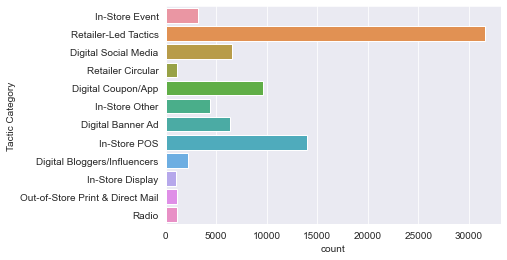

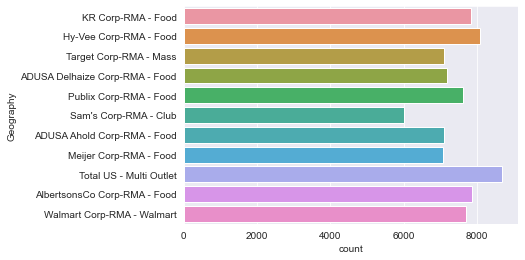

Original number of obs and Tactic Categories
82209
12


In [27]:
for col in df.select_dtypes(include='object'):
    if df[col].nunique() <= 25:
        sns.countplot(y=col, data=df)
        plt.show()

print('Original number of obs and Tactic Categories')
print(df['Tactic Category'].count())
print(df['Tactic Category'].nunique())

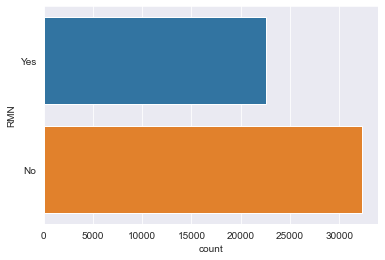

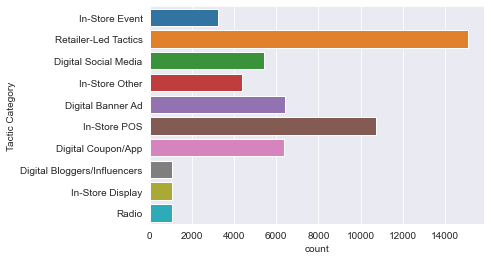

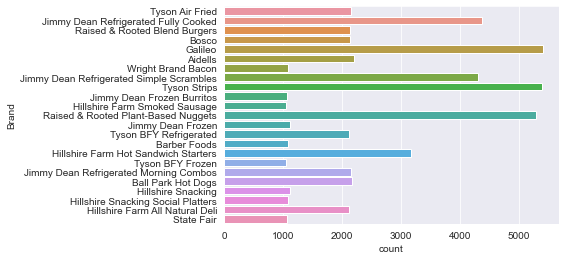

Number of obs, new tactics, and new displays
54886
10
23


In [28]:
for col in df_final_cat.select_dtypes(include='object'):
    if df_final_cat[col].nunique() <= 25:
        sns.countplot(y=col, data=df_final_cat)
        plt.show()

print('Number of obs, new tactics, and new displays')
print(df_final_cat['Tactic Category'].count())
print(df_final_cat['Tactic Category'].nunique())
print(df_final_cat['Brand'].nunique())

In [29]:
tt.config.floatX = 'float64'

df_final_cat = df_bu[final_vars_cat]
df_final_cat = df_final_cat[df_final_cat['Total Sales'] > 0.0]

df_final_cat['Total Sales'] = np.log(df_final_cat['Total Sales'])

price_decr_idxs, price_decr = pd.factorize(df_final_cat['Price Decr Only %ACV'],
                                           sort=True)
tactic_idxs, tactics = pd.factorize(df_final_cat['Tactic Category'], sort=True)
brand_idxs, brand = pd.factorize(df_final_cat['Brand'], sort=True)
coords = {"tactics": tactics, 'brand': brand, 'obs_idx': np.arange(len(tactic_idxs)), 'price_decrease': price_decr}

#### 3. Hierarchical Model with diagnostics

In [ ]:
with pm.Model(coords=coords) as h_model:
    tactic_idx = pm.Data("Tactic Category", tactic_idxs, dims="obs_idx")
    brand_idx = pm.Data("Brand", brand_idxs, dims="obs_idx")
    price_decr = pm.Data("Price Decrease Only", price_decr_idxs, dims="obs_idx")

    # Tactic Category hyperpriors parameters:
    hp_b_0 = pm.Normal("hp_b_0", mu=0.0, sigma=5.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    hp_b_1 = pm.Normal("hp_b_1", mu=0.0, sigma=1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5)

    # Brand hyperpriors parameters
    hp_b_2 = pm.Normal("hp_b_2", mu=0.0, sigma=5.0)
    sigma_c = pm.Exponential("sigma_c", 1.0)
    hp_b_3 = pm.Normal("hp_b_3", mu=0.0, sigma=1.0)
    sigma_d = pm.Exponential("sigma_d", 0.5)

    hp_b_4 = pm.Normal("hp_b_4", mu=0.5, sigma=.3)

    # estimates of independent intercepts and interactions of intercepts
    b_0 = pm.Normal("tactic_int", mu=hp_b_0, sigma=sigma_a, dims="tactics")
    b_1 = pm.Normal("tactic_slope", mu=hp_b_1, sigma=sigma_b, dims="tactics")

    b_2 = pm.Normal("display_int", mu=hp_b_2, sigma=sigma_c, dims="brand")
    b_3 = pm.Normal("display_slope", mu=hp_b_3, sigma=sigma_d, dims="brand")

    price_decr_est = hp_b_4 * price_decr

    # estimate of total sales using intercepts
    sales_est_1 = b_0[tactic_idx] + b_1[tactic_idx] * brand_idx
    sales_est_2 = b_2[brand_idx] + b_3[brand_idx] * tactic_idx
    sales_est = sales_est_1 + sales_est_2 + price_decr_est

    # Data likelihood
    epsilon = pm.Exponential("noise", 1.0)
    Total_Sales = pm.Normal(
            "Log_Total_Sales", mu=sales_est, sigma=epsilon,
            observed=df_final_cat['Total Sales'], dims="obs_idx")

with h_model:
    h_trace = pm.sample(draws=500, init='advi+adapt_diag', chains=4,
                                   cores=4, tune=250,
                                   target_accept=0.7, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO:pymc3:Initializing NUTS using advi+adapt_diag...


Convergence achieved at 56600
INFO:pymc3.variational.inference:Convergence achieved at 56600
Interrupted at 56,599 [28%]: Average Loss = 1.6579e+06
INFO:pymc3.variational.inference:Interrupted at 56,599 [28%]: Average Loss = 1.6579e+06
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, display_slope, display_int, tactic_slope, tactic_int, hp_b_4, sigma_d, hp_b_3, sigma_c, hp_b_2, sigma_b, hp_b_1, sigma_a, hp_b_0]
INFO:pymc3:NUTS: [noise, display_slope, display_int, tactic_slope, tactic_int, hp_b_4, sigma_d, hp_b_3, sigma_c, hp_b_2, sigma_b, hp_b_1, sigma_a, hp_b_0]


In [ ]:
with h_model:
    model_ppc = pm.sample_posterior_predictive(
            h_trace, h_model)

In [ ]:
print('Model R-Squared')
print(az.r2_score(df_final_cat['Total Sales'].values, model_ppc['Log_Total_Sales']))
def score_model(trace,y,model_name):
    """

    :param trace: trace from PyMC3 plot
    :param y: samples
    :param model_name: model from PyMC3
    """
    post_ppc = pm.sample_posterior_predictive(trace, samples=20841,
                                         model=model_name)
    pred = post_ppc['Log_Total_Sales'].mean(axis=0)
    mse = np.sqrt(mean_squared_error(y, pred))
    print('The Mean Squared Error')
    print(mse)

score_model(h_trace, df_final_cat['Total Sales'], h_model)

print('Trace Summary and Effective Sample Size')
print(az.summary(h_trace, kind='stats'))
print(az.summary(h_trace, kind='diagnostics'))
az.plot_posterior(h_trace, hdi_prob=0.99)
az.plot_energy(h_trace)
plt.show()
print('Bayesian fraction of missing information')
print(az.bfmi(h_trace))
az.plot_forest(h_trace, kind='ridgeplot')

In [ ]:
pm.model_to_graphviz(h_model)